
# PJM Hourly Load Forecasting — SARIMA with GARCH(1,1)

This notebook demonstrates a complete **hourly** forecasting workflow electricity demand data:
- Load **hourly** energy consumption (MW) from the Kaggle dataset “Hourly Energy Consumption”.
- Prepare a strict hourly time index (handle missing timestamps).
- Split chronologically into train/test (no shuffling).
- Fit a **SARIMA** model (single seasonal period).
- Fit **GARCH(1,1)** on SARIMA residuals to model conditional variance.
- Forecast and evaluate on the test set.


## 0) Install required packages (quiet)
We install any missing packages quietly so the notebook remains readable.


In [1]:
# Install Kaggle and ARCH (quietly)
!pip install kaggle arch -q

## 1) Imports, plotting defaults, and helper functions

In this section we import the Python libraries needed for the forecasting workflow and set a few global plotting defaults.

- **Core stack**
  - `numpy`, `pandas`: numerical arrays and time-indexed data structures.
  - `matplotlib.pyplot`: visualization.

- **Time-series modeling (statsmodels)**
  - `SARIMAX` for seasonal ARIMA modeling of the **mean** electric load.
  - `adfuller`, `kpss` for quick **stationarity diagnostics**.
  - `het_arch` for the **ARCH LM** test (checks if variance changes over time).

- **Evaluation**
  - `mean_absolute_error`, `mean_squared_error` from `sklearn.metrics` for simple accuracy metrics (MAE, RMSE).

- **Convenience helpers**
  - `show_series(y, ...)`: one-line time-series plot with readable fonts and labels.
  - `rmse(y_true, y_pred)`: square-root of MSE, a common error metric complementary to MAE.

In [2]:
# Suppress warnings to keep output clean
import warnings
warnings.filterwarnings("ignore")

# Core libraries
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Time series modeling and diagnostics
from statsmodels.tsa.statespace.sarimax import SARIMAX   # SARIMA model
from statsmodels.tsa.stattools import adfuller, kpss     # Stationarity tests
from statsmodels.stats.diagnostic import het_arch        # ARCH LM test for heteroskedasticity

# Metrics for forecast evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set global plotting defaults (larger, consistent figures)
plt.rcParams.update({
    "figure.figsize": (11, 5),
    "figure.dpi": 120,
    "axes.grid": True
})

# Helper function: plot a time series with labels and styling
def show_series(y, title="", xlabel="Time", ylabel="Value", fontsize=13):
    fig, ax = plt.subplots()
    ax.plot(y.index, y.values, lw=0.7, alpha=0.8)
    ax.set_title(title, fontsize=fontsize+1)
    ax.set_xlabel(xlabel, fontsize=fontsize-1)
    ax.set_ylabel(ylabel, fontsize=fontsize-1)
    plt.tight_layout()
    plt.show()

# Helper function: compute RMSE given true vs predicted values
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

## 2) Acquire and load the Kaggle dataset (PJM hourly)

In this step we bring in the **PJM Interconnection hourly electricity load dataset** from Kaggle.

- **About the dataset**
  This dataset, hosted on Kaggle, contains **hourly electricity consumption (MW)** for several U.S. regional transmission organizations.
  We will focus on the **PJM Interconnection (PJM)**, which coordinates the wholesale electricity market across the Mid-Atlantic region.

- **About Kaggle**
  Kaggle is a platform for data science and machine learning that hosts datasets, code notebooks, and competitions.
  Access requires either:
  - the `kagglehub` helper (easy one-liner download), or
  - the official `kaggle` API (needs an account and API key in `~/.kaggle/kaggle.json`).

- **Workflow in this cell**
  1. Attempt to download using `kagglehub` (if installed).
  2. If not available, fall back to the `kaggle` API.
  3. If neither is available, raise a message asking the user to **manually download the dataset** from the Kaggle webpage.

- **Output**
  The result will be a **raw DataFrame** (`df_raw`) containing the PJM hourly load series, which we’ll clean and reindex in the next step.

> ⚡ Electricity load data at this granularity is rich: it captures **daily cycles, weekly cycles, and long-term yearly patterns**, making it ideal for testing SARIMA and GARCH models.

In [3]:
pjm_csv = None  # will hold the path to the PJM CSV once found

# --- Try kagglehub first (simplest download if installed) ---
try:
    import kagglehub

    path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")
    base = pathlib.Path(path)
    candidates = (list(base.glob("PJM_hourly.csv"))
                  + list(base.glob("*PJM*hourly*.csv"))
                  + list(base.glob("*PJM*.csv")))
    if candidates:
        pjm_csv = candidates[0]
        print("[kagglehub] Using:", pjm_csv)
except Exception as e:
    print("[kagglehub] Not available/failed:", e)

# --- If kagglehub didn't work, try Kaggle CLI API ---
if pjm_csv is None:
    try:
        import kaggle

        dl_dir = "./kaggle_data"
        os.makedirs(dl_dir, exist_ok=True)
        kaggle.api.dataset_download_files(
            "robikscube/hourly-energy-consumption",
            path=dl_dir, unzip=True
        )
        base = pathlib.Path(dl_dir)
        candidates = (list(base.glob("PJM_hourly.csv"))
                      + list(base.glob("*PJM*hourly*.csv"))
                      + list(base.glob("*PJM*.csv")))
        if candidates:
            pjm_csv = candidates[0]
            print("[kaggle] Using:", pjm_csv)
        else:
            print("[kaggle] Downloaded, but PJM file not found; inspect:", dl_dir)
    except Exception as e:
        print("[kaggle] CLI not available/failed:", e)

# --- If neither method worked, raise an error so the user knows ---
if pjm_csv is None:
    raise FileNotFoundError("PJM hourly CSV not found.")

# --- Load and trim to last 2 years ---
df_raw = pd.read_csv(pjm_csv)

# Find a datetime-like column
time_col = None
for c in df_raw.columns:
    if "date" in c.lower() or "time" in c.lower():
        time_col = c
        break
if time_col is None:
    raise ValueError(f"No datetime column found: {list(df_raw.columns)}")

# Parse as datetime (faster)
df_raw[time_col] = pd.to_datetime(df_raw[time_col], infer_datetime_format=True)

# Trim to last 2 years
cutoff = df_raw[time_col].max() - pd.DateOffset(years=2)
df_raw = df_raw[df_raw[time_col] >= cutoff]

print("Trimmed shape (last 2 years):", df_raw.shape)
df_raw.head()

[kagglehub] Using: /Users/victormpreciado/.cache/kagglehub/datasets/robikscube/hourly-energy-consumption/versions/3/PJMW_hourly.csv
Trimmed shape (last 2 years): (17521, 2)


,Datetime,PJMW_MW
120527,2016-12-31 01:00:00,5744.0
120528,2016-12-31 02:00:00,5664.0
120529,2016-12-31 03:00:00,5619.0
120530,2016-12-31 04:00:00,5643.0
120531,2016-12-31 05:00:00,5716.0


## 3) Make a strict hourly time index (no gaps), keep **hourly** data

The raw Kaggle dataset provides timestamps and hourly load values, but:
- Some hours may be **missing** (e.g., due to daylight savings or reporting gaps).
- The `DatetimeIndex` might not carry a clear **frequency attribute**, which is required for seasonal models in `statsmodels`.

To make the data ready for modeling we:

1. **Identify columns**
   - Detect the timestamp column (e.g., `Datetime` or `Datetime EST`).
   - Detect the target column, typically ending in `_MW` (megawatts).

2. **Set a proper time index**
   - Convert the timestamp to `DatetimeIndex`.
   - Sort the index to ensure chronological order.

3. **Reindex to a continuous hourly grid**
   - Build a complete hourly range between the first and last timestamp.
   - Reindex the series to this new grid.
   - This step introduces `NaN` for any missing hours.

4. **Impute missing values**
   - Fill missing values by **time-based interpolation** (smoothly interpolates between known points).
   - Alternative domain-specific options include forward-fill/back-fill.

5. **Finalize the time series**
   - Ensure the index has a strict hourly frequency (`asfreq("H")`).
   - Confirm with `pd.infer_freq` that the index is hourly.
   - Store the cleaned hourly series in `y`.

> Having a **continuous hourly time series with no gaps** is crucial for SARIMA and GARCH, since these models rely on the assumption of regular spacing in the data.

Found 2 duplicated timestamps. Aggregating duplicates by mean.
Hourly series length: 17521
Inferred freq: h


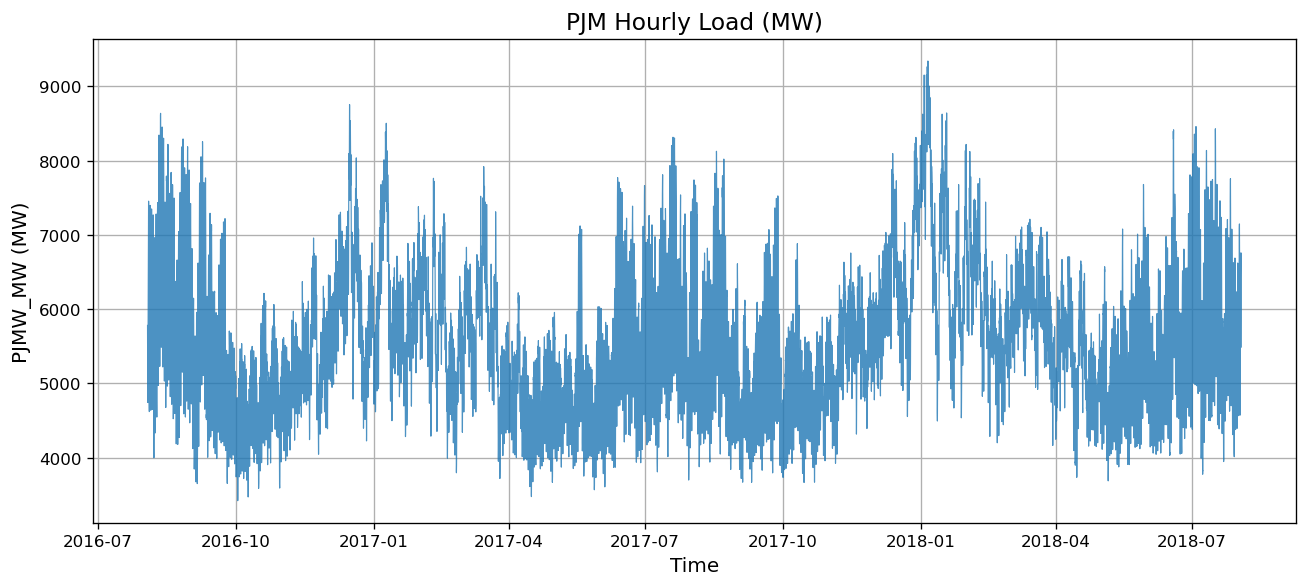

In [4]:
# Make a working copy of the raw dataframe
df = df_raw.copy()

# Strip whitespace from column names and build a lowercase lookup
df.columns = [c.strip() for c in df.columns]
cl = {c.lower(): c for c in df.columns}

# --- Detect timestamp column ---
time_col = None
for key in ("datetime", "date", "timestamp", "time"):
    if key in cl:
        time_col = cl[key]
        break
if time_col is None:
    raise ValueError(f"No time column found. Columns: {list(df.columns)}")

# Parse timestamp column to datetime, set as index, and sort chronologically
df[time_col] = pd.to_datetime(df[time_col])
df = df.set_index(time_col).sort_index()

# --- Detect load (MW) column ---
# Prefer columns ending with "_MW", otherwise pick first numeric column
mw_col = None
for c in df.columns:
    if c.upper().endswith("_MW"):
        mw_col = c
        break
if mw_col is None:
    num_cols = df.select_dtypes(include=["number"]).columns.tolist()
    if not num_cols:
        raise ValueError("No numeric columns found.")
    mw_col = num_cols[0]

# Keep only the load column as a Series with datetime index
y = df[mw_col].astype(float).sort_index()

# --- Handle duplicate timestamps (e.g., DST or repeated rows) ---
if y.index.has_duplicates:
    dup_cnt = int(y.index.duplicated().sum())
    print(f"Found {dup_cnt} duplicated timestamps. Aggregating duplicates by mean.")
    y = y.groupby(y.index).mean()

# --- Reindex to a continuous hourly grid ---
full_idx = pd.date_range(y.index.min(), y.index.max(), freq="H")
y = y.reindex(full_idx)

# --- Impute missing values ---
y = y.interpolate("time")
# y = y.ffill().bfill()

# --- Sanity check: no NaNs should remain ---
na_cnt = int(y.isna().sum())
if na_cnt > 0:
    raise ValueError(f"Found {na_cnt} NaNs after imputation. Adjust the imputation strategy.")

# --- Finalize series ---
y.name = y.name or mw_col
y = y.asfreq("H")

# Downcast for a tiny memory/speed win
y = y.astype("float32")

# Report and visualize
print("Hourly series length:", len(y))
print("Inferred freq:", pd.infer_freq(y.index))  # should be 'H'
show_series(y, title="PJM Hourly Load (MW)", ylabel=f"{mw_col} (MW)")

## 4) Train / Test split (no shuffling)

Once the dataset is cleaned and aligned to a strict hourly grid, we need to divide it into
**training** and **testing** segments.

- **Why not shuffle?**
  In contrast to cross-sectional datasets, time series observations are ordered in time and
exhibit strong dependencies between past and future values.
Shuffling would destroy this temporal structure and make forecasting meaningless.

- **How we split:**
  - The **training set** is the earlier portion of the series (e.g., the first 80%).
  - The **test set** is the most recent portion (e.g., the last 20%).
  - This mimics a real forecasting task: at prediction time we only have access to the past,
    and we want to assess how well the model predicts the unseen future.

- **Optional refinement:**
  Depending on the problem, the split can be chosen to align with full seasonal cycles
(e.g., whole weeks or years), so both train and test sets contain complete seasonality patterns.

> This setup ensures that evaluation metrics (MAE, RMSE) reflect the model’s
ability to generalize to *future* unseen data, not just to randomly held-out points.

Train length: 13944  Test length: 3577


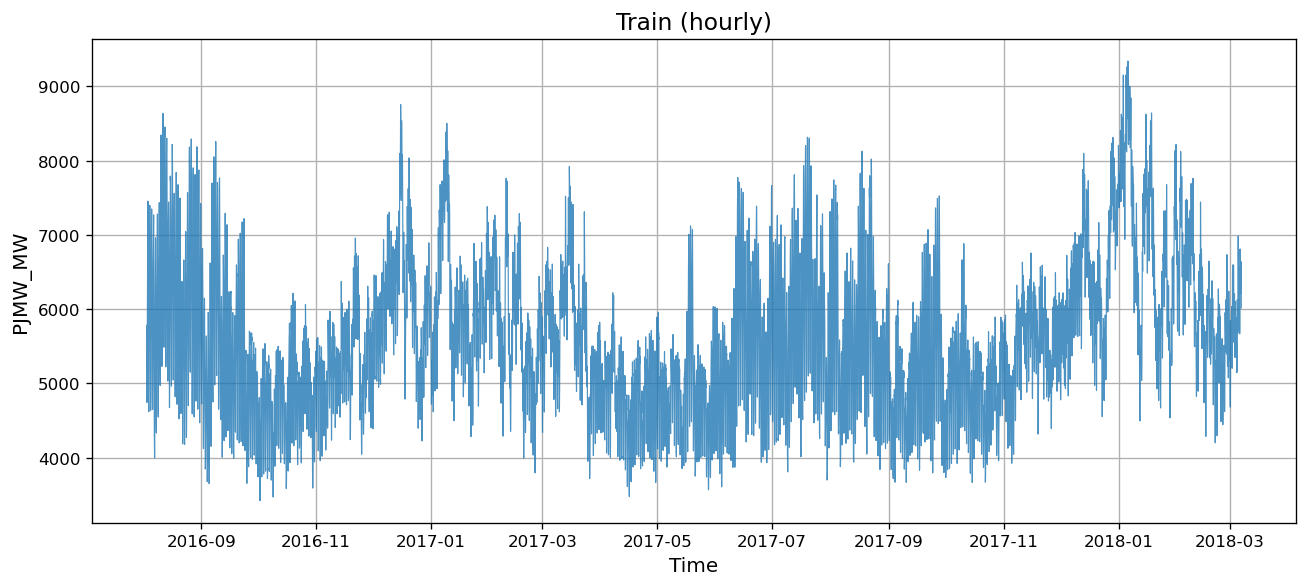

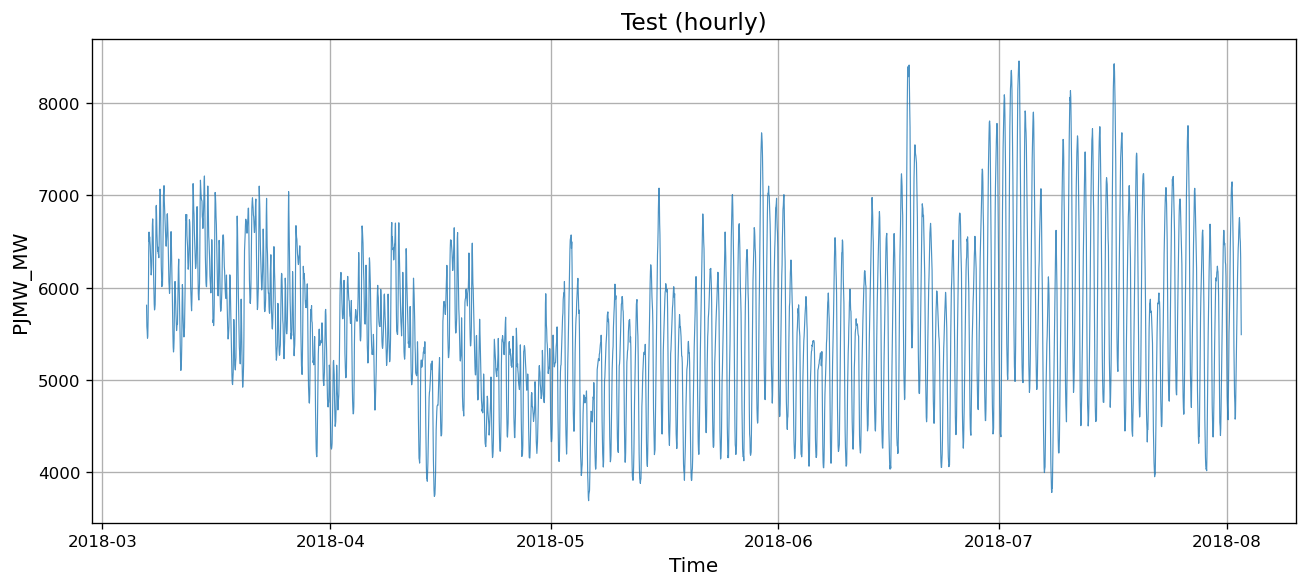

In [5]:
# Fraction of the dataset to use for training (80% train, 20% test)
split_frac = 0.8

# Compute the split index based on the total length of the series
split_idx = int(len(y) * split_frac)

# Align split to full seasonal cycles (weeks)
s = 168
split_idx -= (split_idx % s)

# Create the training set (first 80% of the data)
y_train = y.iloc[:split_idx].asfreq("H")

# Create the test set (remaining 20% of the data)
y_test = y.iloc[split_idx:].asfreq("H")

print("Train length:", len(y_train), " Test length:", len(y_test))

show_series(y_train, title="Train (hourly)", ylabel=y.name)
show_series(y_test, title="Test (hourly)", ylabel=y.name)

## 5) SARIMA baseline (weekly seasonality)

We fit a **Seasonal ARIMA** model to the **hourly** load series using a single seasonal period:

- **Why weekly seasonality (`s = 168`)?**
  Hourly electricity load exhibits strong **daily (24h)** and **weekly (7×24=168h)** cycles.
  Classic SARIMA can include **one seasonal period**; starting with **weekly** often captures both the weekday/weekend structure and a large share of the daily pattern.

- **Model orders (what the tuples mean)**
  - `order = (p, d, q)`
    - `p`: AR order (dependence on past values)
    - `d`: nonseasonal differencing (remove slow drift)
    - `q`: MA order (dependence on past shocks)
  - `seasonal_order = (P, D, Q, s)`
    - `P`: seasonal AR order
    - `D`: **seasonal differencing** (remove seasonal mean shifts)
    - `Q`: seasonal MA order
    - `s`: seasonal period (here, `168` hours for weekly)

- **Starting values**
  We begin with a **simple baseline** (e.g., `order=(1,1,1)`, `seasonal_order=(1,1,1,168)`) to keep runtime manageable and avoid an exhaustive grid search.
  If diagnostics suggest underfitting (autocorrelation remains), you can modestly increase `p/q` or `P/Q`.

- **Flags**
  - `enforce_stationarity=False`, `enforce_invertibility=False`
    These are relaxed initially to avoid convergence failures; if the model converges well, you can try setting them to `True` in later iterations.

- **Good practice**
  - Consider a **log transform** if variance grows with the level (`np.log1p(y)` / `np.expm1()` for back-transform).
  - Always **check residuals** (next step): they should be close to white noise; otherwise, adjust orders or differencing.

> SARIMA handles one seasonal period at a time. For **multiple seasonalities** (24, 168, 8760), consider adding **Fourier terms** or using models like **TBATS**; here we intentionally keep the baseline simple and fast.

In [6]:
s = 168

sarima_model = SARIMAX(
    y_train,
    order=(1, 0, 1),  # d=0 (we difference via simple_differencing)
    seasonal_order=(1, 0, 1, s),  # D=0 (seasonal differencing handled up-front)
    trend='n',
    simple_differencing=True,
    hamilton_representation=True,
    concentrate_scale=True,
    enforce_stationarity=False,
    enforce_invertibility=False,
    validate_specification=False
).fit(method='lbfgs', maxiter=200, disp=False)

print(sarima_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                             PJMW_MW   No. Observations:                13944
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 168)   Log Likelihood              -80181.883
Date:                             Thu, 11 Sep 2025   AIC                         160373.767
Time:                                     16:49:22   BIC                         160411.420
Sample:                                 08-03-2016   HQIC                        160386.312
                                      - 03-06-2018   Scale                         6636.880
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9913      0.001    938.309      0.000       0.989       0.993
ma.L1          0.3362      

## 6) SARIMA forecast on test horizon

With the SARIMA model fitted on the **training** data, we now generate and evaluate **out-of-sample** forecasts for the **test** period.

### What this cell does
1. **Define the horizon**
   - We set the number of forecast steps to the **length of the test set**, rounded down to a whole number of weeks (168 hours), so evaluation covers complete seasonal cycles.

2. **Produce forecasts and intervals**
   - `sarima_model.get_forecast(steps=n_test)` returns:
     - `predicted_mean`: the point forecast for each hour in the test horizon.
     - `conf_int(alpha=0.05)`: the **95% prediction interval** (lower/upper bands), which reflects both model and observation uncertainty under the SARIMA assumptions.
   - We align the confidence interval index to the forecast index for clean plotting.

3. **Visualize**
   - Plot **actual** test data vs **forecast** trajectory, shading the **95% prediction interval**.

4. **Evaluate accuracy**
   - Compute **MAE** (Mean Absolute Error) and **RMSE** (Root Mean Squared Error) over the aligned test period.

### Notes & good practice
- These are **direct multi-step** forecasts (the model recursively projects forward over the full horizon).
- If your series has **time-varying variance** (heteroskedasticity), SARIMA’s intervals may appear **over- or under-confident**; consider variance modeling (e.g., **GARCH**) for improved uncertainty quantification.
- Make sure the model and the data share a known **hourly frequency**; otherwise `statsmodels` may warn that the date index is ignored when forecasting.

Aligning test horizon from 3577 to 3528 hours (whole weeks).


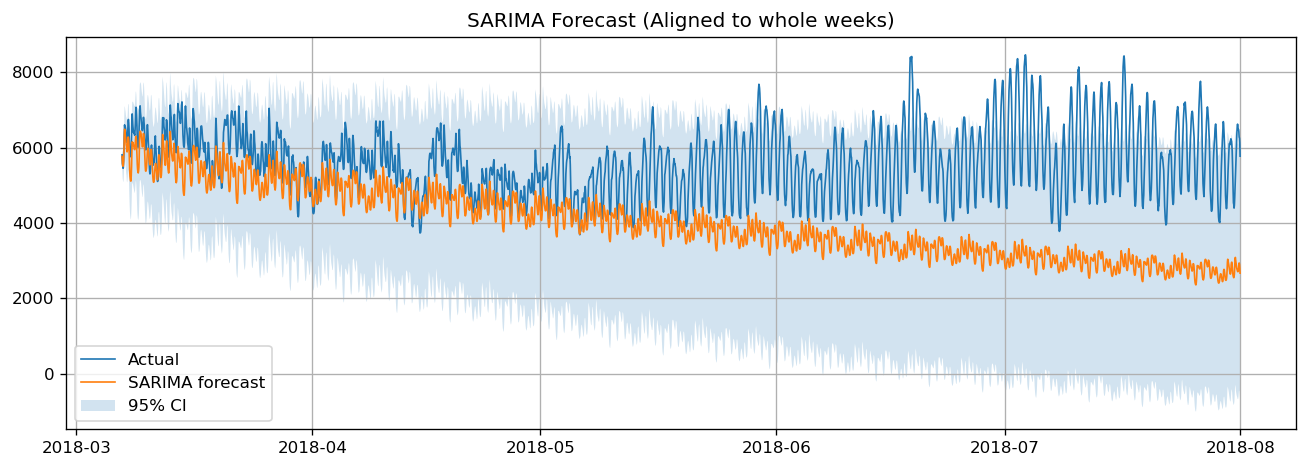

SARIMA MAE:  1600.909
SARIMA RMSE: 2007.824


In [7]:
# Align forecast horizon to whole weeks (s = 168 hours)
s = 168
n_test_full = len(y_test)
n_test = (n_test_full // s) * s
if n_test < n_test_full:
    print(f"Aligning test horizon from {n_test_full} to {n_test} hours (whole weeks).")

# Use the aligned test slice for evaluation/plotting
y_test_aligned = y_test.iloc[:n_test]

# Generate out-of-sample forecasts for the aligned horizon
sarima_fc_res = sarima_model.get_forecast(steps=n_test)

# Extract point forecasts (one per hour in the test horizon)
sarima_fc = sarima_fc_res.predicted_mean

# Extract 95% prediction intervals (lower/upper bounds)
sarima_ci = sarima_fc_res.conf_int(alpha=0.05)

# Align forecast and CI indices to the aligned test period
sarima_fc.index = y_test_aligned.index
sarima_ci.index = sarima_fc.index

# --- Plot actual vs forecast with 95% CI ---
fig, ax = plt.subplots(figsize=(11,4))
ax.plot(y_test_aligned.index, y_test_aligned.values, label="Actual", lw=1.0)
ax.plot(sarima_fc.index, sarima_fc.values, label="SARIMA forecast", lw=1.0)
ax.fill_between(sarima_ci.index, sarima_ci.iloc[:, 0], sarima_ci.iloc[:, 1],
                alpha=0.2, label="95% CI")
ax.set_title("SARIMA Forecast (Aligned to whole weeks)")
ax.legend()
plt.tight_layout()
plt.show()

# --- Accuracy metrics on the aligned test horizon ---
sarima_mae  = mean_absolute_error(y_test_aligned, sarima_fc)  # average absolute error (MW)
sarima_rmse = rmse(y_test_aligned, sarima_fc)                 # penalizes larger errors more (MW)

print(f"SARIMA MAE:  {sarima_mae:.3f}")
print(f"SARIMA RMSE: {sarima_rmse:.3f}")

## 7) GARCH(1,1) on SARIMA residuals (variance modeling)

SARIMA models the **conditional mean** of the series. In many energy/load datasets, however, the **variance changes over time**
(e.g., higher volatility during extreme weather or holidays). To capture this **time-varying volatility**, we model the **residuals**
from SARIMA with a **GARCH(1,1)** process.

### What we do in this step
1. **Extract residuals** from the fitted SARIMA model:
   \( Y_t = \mu_t + \varepsilon_t \), where \( \mu_t \) is the SARIMA mean and \( \varepsilon_t \) are the residuals.
2. **Center residuals** (optional, usually mean ~ 0 already).
3. **Fit GARCH(1,1)** on residuals:
   \[
   \varepsilon_t = \sigma_t z_t,\quad z_t \sim \text{i.i.d. }(0,1), \qquad
   \sigma_t^2 = \omega + \alpha_1 \varepsilon_{t-1}^2 + \beta_1 \sigma_{t-1}^2.
   \]
   - \( \omega > 0 \): long-run variance level.
   - \( \alpha_1 \ge 0 \): reaction to **recent shocks** (ARCH effect).
   - \( \beta_1 \ge 0 \): **persistence** of volatility (GARCH effect).
   - A common **persistence** measure is \( \alpha_1 + \beta_1 \). Values close to 1 imply highly persistent volatility.
4. **Inspect the summary**: coefficients, significance, and diagnostics.

### Why this helps
- If the **ARCH LM test** on residuals was significant, the residual variance is not constant (heteroskedastic).
- GARCH provides **conditional variance forecasts** \( \hat{\sigma}_{t+h}^2 \), which can improve **prediction intervals** and risk assessment.

### Interpretation tips
- If \( \alpha_1 \) is large → volatility reacts strongly to new shocks.
- If \( \beta_1 \) is large → volatility decays slowly (high persistence).
- If \( \alpha_1 + \beta_1 \approx 1 \) → volatility is very persistent; if \(\ll 1\) → volatility mean-reverts faster.

### Practical notes
- Distribution of \( z_t \): default is **normal**; heavy tails (e.g., **t** distribution) can be more realistic for spiky residuals.
- If variance scales with level, consider modeling **log-transformed** load (e.g., `np.log1p(y)`), then back-transform forecasts.
- GARCH here refines **uncertainty** (variance); it does **not** change the SARIMA **mean** forecast. To build volatility-aware intervals, combine the mean forecast with \(\hat{\sigma}_t\) from GARCH.

> Outcome: a **two-layer model** — SARIMA for the mean (\(\mu_t\)), GARCH for the variance (\(\sigma_t^2\)). This is a common and effective strategy for financial and energy time series.

In [8]:
try:
    # Import the ARCH package (used for volatility models like GARCH)
    from arch import arch_model

    # Get residuals from the fitted SARIMA model and drop missing values
    resid = sarima_model.resid.dropna()

    # ARCH LM test (24 hourly lags ~ one day)
    lm_stat, lm_pval, _, _ = het_arch(resid, nlags=24)
    print(f"ARCH LM p-value (24 lags): {lm_pval:.3g}")
    if lm_pval >= 0.05:
        print("No strong ARCH effects — skipping GARCH fit.")
    else:
        # Center residuals around zero (optional)
        resid_c = resid - resid.mean()

        # Use Student-t innovations (often better for spikes)
        garch = arch_model(resid_c, vol='GARCH', p=1, q=1, dist='t')

        # Fit the GARCH model
        garch_res = garch.fit(update_freq=0, disp="off")

        # Print a detailed summary of estimated GARCH parameters
        print(garch_res.summary())

except Exception as e:
    # If arch is not installed or fitting fails, skip this step gracefully
    print("GARCH step skipped (arch not available or fitting failed):", e)

ARCH LM p-value (24 lags): 0
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -81246.0
Distribution:      Standardized Student's t   AIC:                           162502.
Method:                  Maximum Likelihood   BIC:                           162540.
                                              No. Observations:                13944
Date:                      Thu, Sep 11 2025   Df Residuals:                    13943
Time:                              16:49:26   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------